<div style="background-color:white;color:black;padding:30px;">

<center>
    <h1>
    Lyrics2Chords
    </h1>
</center>

<p>
   This notebook contains code used to build and train the lyric emotional sentiment classifier used in the back end of the Lyrics2Chords web application. The model was trained on data containing song lyrics as the input features using the valence score attained from the Spotify API as a proxy for the emotional sentiment of the song. The valence score is then binarized into a category of low and high valence. The valence score Spotify provides is determined solely from the musical qualities of the song. Thus, one of the model assumptions relies on every song's lyrics and musical voicings are within the same valence class. Though there were a number of songs that broke from this assumption but the majority of songs appeared to obey this trend.
</p>

<p>
This notebook is organized as follows
</p>

<ul>
  <li>Begin by loading necessary python libraries and import data stored in csv file 
      (containing ~2k songs)  to a pandas dataframe for analysis
  </li>
  <li>
      The song lyric data then goes through a round of refinement and some natural language 
      processing to clean the data and make it amenable to apply machine learning algorithms on
  </li>
  <li>
      A number of machine learning models were trained on 80% of the data 
      and then combined into a stacked ensemble 
      classifier whose performance was slightly better than any sub-model contained within it
  </li>
</ul>

<p>
The resulting model achieved an accuracy score of 0.64 with an area under the ROC curve of 0.67 on the holdout set. Compared to results of binary sentiment classification from standard datasets like the IMDB movie reviews dataset
this may seem underwhelming. However, song lyrics are shrouded in metaphors, simile, and other poetic devices
that makes this classification much less straightforward for ML algorithms to accurately classify to the same degree as classifying reviews. 
</p>



</div>

In [88]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy
import random

import matplotlib as pl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


import pickle


import sklearn as skl
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin ,clone
from sklearn.preprocessing import StandardScaler, RobustScaler 
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, confusion_matrix , auc, accuracy_score

import string
import re
import nltk
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer

from langdetect import detect
from time import sleep
from time import time
from scipy.stats import randint as sp_randint


import itertools
from itertools import islice
import codecs
import unicodedata





In [96]:
dat = pd.read_csv('../THE_DF_9_27.csv')
dat.drop(labels=['Unnamed: 0'], axis = 1, inplace=True)
dat.drop(labels=['track_href','type','uri',], axis = 1, inplace=True)
dat['lyrics'] = dat[['lyrics']].apply(lambda x: x.astype(str).str.lower()).lyrics.values
dat = dat.drop_duplicates()

dat[['artist','song','lyrics','valence']].head()



,artist,song,lyrics,valence
0,10cc,the wall street shuffle,do the wall street shuffle hear the money rust...,0.6730
1,3 Doors Down,kryptonite,i took a walk around the world to ease my trou...,0.5430
2,311,amber,"brainstorm, take me away from the norm i got t...",0.7480
3,5 Seconds Of Summer,amnesia,i drove by all the places we used to hang out ...,0.1080
4,A Great Big World,say something,"say something, i'm giving up on you i'll be th...",0.0765


<div style="background-color:white;color:black;padding:30px;">
<h2>
Preparing the Data
</h2>
<p>
In the next three cells I begin by making a  copying the data frame and then
removing text within the lyrics in parentheses or brackets. This was useful
in getting rid of non-lyrical text such as information on what album the song
appeared on or which section of the song the lyrics were found in.
</p>

<p>
I then create a new feature which counts the number of characters in each songs lyrics.
I chose to delete any song with fewer than 60 characters. This gets rid of songs
which are largely instrumental.
</p>

<p>
Next, using the langdetect python package the language of each song is determined and
I keep only the songs that are in English.
</p>

<p>
I then define helper functions to stem and tokenize the lyrical text which I then implement
in the following cell.
</p>
<div>

In [3]:
dat_cp = dat[['artist','song','lyrics','valence']].copy()


dat_cp['lyrics'] = dat_cp['lyrics'].apply(lambda x: re.sub('\(.*?\)','',x))
dat_cp['lyrics'] = dat_cp['lyrics'].apply(lambda x: re.sub('\[.*?\]','',x))
dat_cp['lyrics'] = dat_cp['lyrics'].apply(lambda x: re.sub('\{.*?\}','',x))
dat_cp['lyrics'] = dat_cp['lyrics'].apply(lambda x: re.sub('-',' ',x))


#remove instrumental songs or songs  
dat_cp['lyric_len'] = dat_cp['lyrics'].apply(lambda x: len(x))
dat_cp = dat_cp[dat_cp['lyric_len'] > 60]

#remove non-english songs
dat_cp['lang'] = dat_cp['lyrics'].apply(lambda x: detect(x))
dat_cp = dat_cp[dat_cp['lang'] == 'en']

dat_cp = dat_cp.reset_index(drop = True)

In [4]:
stemmer = PorterStemmer()

def stem_tokens(tokens, stemmer):
    """
    helper fuction that takes in work tokens and stemmer
    and returns stemmed word tokens
    """
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    """
    word tokenizer that takes in raw text and returns 
    a tokenized list of words
    """
    tokens = word_tokenize(text)
    stems = stem_tokens(tokens, stemmer)
    return stems




In [6]:
stemmed_lyrics = dat_cp.lyrics.apply(lambda x: tokenize(x.replace(',',' ').replace('.',' ').replace('  ',' ')))
stemmed_lyrics = stemmed_lyrics.apply(lambda x: ' '.join(x))

In [7]:
# The continuous valence score is binarized to 0 and 1
#   valence = 0 corresponds to low valence   (sad, angry)
#   valence = 1 corresponds to high valence  (happy, calm)
def discrete_val(valence, classes):
    if classes == 2:
        if valence < .515:
            return 0
        else:
            return 1

<div style="background-color:white;color:black;padding:30px;">
<h2>
Preparing the Data cont...
</h2>
<p>
Below, the lyrical text is vectorized by way of a word count vectorizer that excludes common stop words 
found in the NLTK's english stopwords list and doesn't count words that have a document frequency 
greater than 95 percent or lower than 5 percent. The reason for excluding low frequency words was
to eliminate proper nouns appearing in songs as they don't supply and information about the sentiment 
of the songs. I arrived at the five percent threshold through some experimentation and finding that the
models accuracy on the training set was optimal for this cutoff. A TFIDF transformer is then applied. The
thought behind this was to weight commonly occurring words in songs less than those appearing in many songs
and words that appear often in each song should be weighed more as these are words probably occurring in the
chorus of the song which usually contains the message of the song and may carry significant information regarding
the songs emotional sentiment.
 </p>

<p>
The dataset if then split up into a 80-20 train-test split. The model parameters of the classifiers
later in the notebook were optimized on the training set.
</p>


In [8]:
count_vect = CountVectorizer(ngram_range=(1,3), max_df = .95, min_df = .05, stop_words=nltk.corpus.stopwords.words('English'))
X_train_counts = count_vect.fit_transform(stemmed_lyrics.values).toarray()

lyrics_tfidf = TfidfTransformer()
X_train_tfidf = lyrics_tfidf.fit_transform(X_train_counts).toarray()

N_CLASS = 2
IN_DIM = X_train_tfidf.shape[1]

dat_cp['discrete_valence'] = dat_cp.valence.apply(lambda x: discrete_val(x,N_CLASS))
X_train, X_test, Y_train, Y_test = train_test_split(X_train_tfidf, 
                                                    dat_cp['discrete_valence'], 
                                                    test_size=0.2, 
                                                    random_state=42)

y_train = dat_cp.valence

<h2>
Defining Some Helpful Functions for Later
</h2>

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [10]:
def rmsle_cv(model, n_folds, x, y):
    """
     This function was used in another iteration of this notebook
     and was used to get an average accuracy score of k-fold cross-validation
     applied to the model on the training set. This was used to help pick
     the best hyper-paramenters for all of the models except for the
     GradientBoostingClassifier for which scikit-learn's built in
     RandomizedSearchCV was used to find the best model parameters
    """
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(x)
    
    accuracy_score= cross_val_score(model, 
                                   x, 
                                   y, 
                                   scoring='accuracy', 
                                   cv = kf)
    return(accuracy_score)

<div style="background-color:white;color:black;padding:30px;">
<h2>
Machine Learning Model Building
</h2>
<p>
Below, a number of models are trained on the training set and the accuracy scores and confusion matrices
on the test set are then shown for the test set. This may look like I through the book of ML classifiers
at the problem but there was a some thought and a few rounds of iterating through ideas that lead to me
training and ensembling multiple models into a stacked classifier.
</p>

<p>
Some of my earlier approaches began using a Naive Bayes classifier as it has historically had success of 
in text classification challenges such as spam identification. Logistic regression is also a simple
model which has few hyper parameters and is interpretable so it too was used. I then explored the other
models below including a gradient boosting classifier, random forest classifier, and multilayer perceptron
neural network to test models which were able to take into account non-linear effects that logistic regression
couldn't. 
</p>

<p>
The next idea that occurred to me was to ensemble the models. I used a stacked ensemble model which used a max
voting rule to classify the sentiment of the song lyrics. The reason for doing this is that each machine learning
model picks up on different facets based off of their underlying algorithm. Having each model vote on may then perform better than any underlying model. Indeed a subset of the models were chosen that give a slightly better accuracy score than the best sub-model used.
</p>

In [23]:
GBoost = GradientBoostingClassifier(n_estimators = 100, learning_rate = 0.025, random_state= 42)

param_dist = {"max_depth": [2,3],
              "min_samples_split": sp_randint(2, 20),
              "min_samples_leaf": sp_randint(1, 20)}

n_iter_search = 20

random_search = RandomizedSearchCV(GBoost, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search, 
                                   verbose= 1,
                                   cv = 5, 
                                   scoring="accuracy",
                                   n_jobs = -1)

In [24]:
random_search.fit(X_train, Y_train);

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.0min finished


In [25]:
random_search.best_params_

{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 17}

0.6157517899761337
Normalized confusion matrix


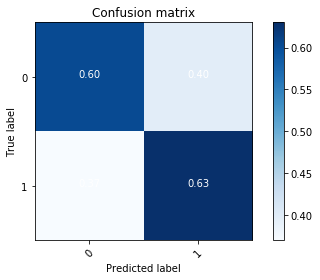

In [26]:
GBoost = GradientBoostingClassifier(n_estimators = 100, random_state= 42,
                                   learning_rate = 0.025, max_depth= 2,
                                    min_samples_leaf = 5, min_samples_split = 17)

GBoost.fit(X_train, Y_train)
print(GBoost.score( X_test, Y_test))

plot_confusion_matrix(confusion_matrix(Y_test,GBoost.predict(X_test )),normalize= True, classes=[i for i in range(N_CLASS)])
plt.show()

0.5966587112171837
Normalized confusion matrix


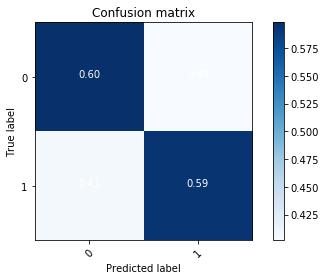

In [27]:
GNB = GaussianNB() 

GNB.fit(X_train,Y_train)
print(GNB.score( X_test, Y_test))

plot_confusion_matrix(confusion_matrix(Y_test,GNB.predict(X_test )),
                      normalize= True, 
                      classes=[i for i in range(N_CLASS)])
plt.show()

0.5799522673031027
Normalized confusion matrix


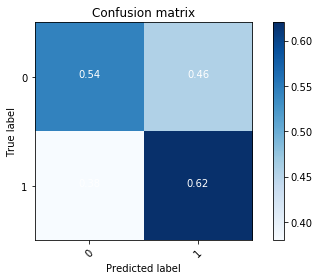

In [28]:
LogReg_mn = LogisticRegression(penalty='l1' ,C =2, multi_class = 'multinomial', solver= 'saga', n_jobs=-1)

LogReg_mn.fit(X_train,Y_train)
print(LogReg_mn.score( X_test, Y_test))
plot_confusion_matrix(confusion_matrix(Y_test,LogReg_mn.predict(X_test)),normalize= True, classes=[i for i in range(N_CLASS)])
plt.show()

0.5847255369928401
Normalized confusion matrix


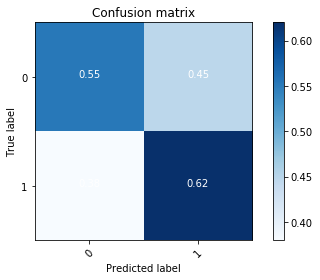

In [29]:
LogReg_ovr = LogisticRegression(penalty= 'l2', C =20, multi_class = 'ovr', n_jobs=2)#, solver= 'newton-cg')

LogReg_ovr.fit(X_train,Y_train)
print(LogReg_ovr.score(X_test,Y_test))
plot_confusion_matrix(confusion_matrix(Y_test,LogReg_ovr.predict(X_test)),normalize= True, classes=[i for i in range(N_CLASS)])
plt.show()

0.6157517899761337
Normalized confusion matrix


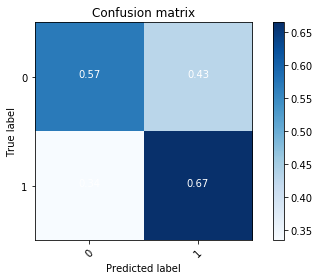

In [30]:
MNB = MultinomialNB(alpha =5)

MNB.fit(X_train,Y_train)
print(MNB.score(X_test,Y_test))
plot_confusion_matrix(confusion_matrix(Y_test,MNB.predict(X_test)),normalize= True, classes=[i for i in range(N_CLASS)])
plt.show()


0.5751789976133651
Normalized confusion matrix


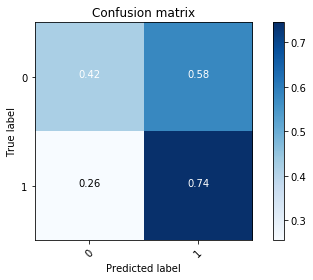

In [31]:
mlp = MLPClassifier(hidden_layer_sizes=(IN_DIM//2,IN_DIM//2,IN_DIM//2,), random_state= 42,early_stopping=True, validation_fraction=0.25)

mlp.fit(X_train,Y_train)
print(mlp.score(X_test,Y_test))
plot_confusion_matrix(confusion_matrix(Y_test,mlp.predict(X_test)),normalize= True, classes=[i for i in range(N_CLASS)])
plt.show()

0.6372315035799523
Normalized confusion matrix


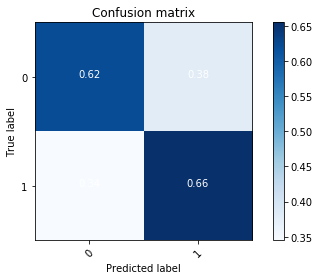

In [98]:
RFC = RandomForestClassifier(n_estimators= 40, max_depth= 5, min_samples_leaf= 10,
                            min_samples_split = 4,criterion= 'gini',
                            max_features = 'auto', random_state = 42)

RFC.fit(X_train,Y_train)
print(RFC.score(X_test,Y_test))

plot_confusion_matrix(confusion_matrix(Y_test,RFC.predict(X_test)),normalize= True, classes=[i for i in range(N_CLASS)])
plt.show()

<h2>
Stacked Classifer
</h2>
Below a class is built to average that will allow me to ensemble models into a stacked max-voting classifier. The models chosen from above that constitute this custom ensemble model were chosen by empirically testing out various combinations and checking to see which performed the best.

In [33]:


class AveragingModels(BaseEstimator, ClassifierMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return scipy.stats.mode(predictions, axis=1)[0]
    
    def predict_proba(self, X):
        predictions = np.column_stack([
            model.predict_proba(X)[:,1] for model in self.models_
            
        ])
        return np.mean(predictions, axis=1)
    

In [74]:
voting_model = AveragingModels([LogReg_ovr, MNB,GBoost,RFC,mlp]);

voting_model.fit(X_train,Y_train);

Modle Accuracy on Test Set: 0.6396
Normalized confusion matrix


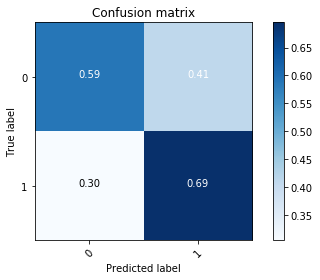

In [94]:
print('Modle Accuracy on Test Set:', round(accuracy_score(Y_test, voting_model.predict(X_test)),4))

plot_confusion_matrix(confusion_matrix(Y_test,voting_model.predict(X_test)),
                      normalize= True, classes=[i for i in range(N_CLASS)])
plt.show()

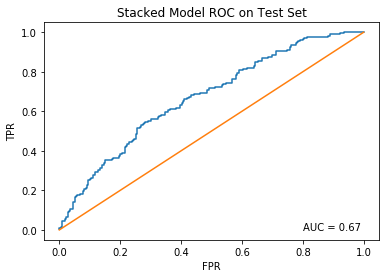

In [83]:
fpr, tpr, thresholds = roc_curve(Y_test, voting_model.predict_proba(X_test))
plt.plot(fpr, tpr, label='RT + LR')
plt.plot([0,1],[0,1])
plt.title('Stacked Model ROC on Test Set')
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.text(.8,0,'AUC = '+ str(round(auc(fpr,tpr),2)))
plt.show()
#auc(fpr,tpr)

<h2>
An Aside
</h2>

Below I check out the words associated largest positive and negative weights of the trained logistic regression model to see what kinds of words the model associated with songs with high and and low emotional valence respectively.

In [86]:
# Top words associated with high emotional valence
# from the logistic regression model
for name, age in count_vect.vocabulary_.items():    
    for i in LogReg_mn.coef_[0].argsort()[-20:][::-1]:
        if age == i:
            print(name)

got
better
long
put
made
touch
pleas
danc
girl
night
line
best
babi
stop
tonight
hit
gon
roll
mine
nobodi


In [87]:
# Top words associated with high emotional valence
# from the logistic regression model
for name, age in count_vect.vocabulary_.items():   
    for i in LogReg_mn.coef_[0].argsort()[:20]:
        if age == i:
            print(name)

walk
bodi
hold
away
thi
fear
far
sometim
start
rememb
fall
alon
close
light
lost
die
god
cri
black
breath


In [ ]:
#### finally we save our models, word vectorizer, and tfidf transformer
CntVector = pickle.dump(count_vect, open('count_vect', 'wb'))
LyricTFIDF = pickle.dump(lyrics_tfidf, open('lyrics_tfidf', 'wb'))

GBoost,RFC,mlp
LogRegModel = pickle.dump(LogReg_ovr, open('LogReg_model', 'wb'))
NBModel = pickle.dump(MNB, open('NB_model', 'wb'))
GBoostModel = pickle.dump(GBoost, open('GBoost_model', 'wb'))
RFCModel = pickle.dump(MNB, open('RFC_model', 'wb'))
MLPModel = pickle.dump(mlp, open('MLP_model', 'wb'))
VotingModel = pickle.dump(voting_model, open('voting_model', 'wb'))